# Deep Learning Models

This strategy attempts to use deep learning to predict future stock prices.

## Initialization

In [1]:
# initialize the module and import all libraries
from init import *
import torch
import torch.nn as nn
import torch.optim as optim

## Config

### Data Range and Symbols

In [2]:
START_DATE = "2016-01-01"
END_DATE = "2023-01-01"
VAL_START_DATE = "2023-01-01"
VAL_END_DATE = "2024-01-01"
INTERVAL = "1d"
SYMBOL = "AAPL"
INDICATOR_SYMBOLS = ["SPY"]

### Indicator Config

In [3]:
EMA_RATIO_SPAN = 20

BBP_WINDOW_SIZE = 10
BBP_NUM_STDDEVS = 2

PPO_SHORT_SPAN = 5
PPO_LONG_SPAN = 30

MOMENTUM_LOOKBACK_1 = 20
MOMENTUM_LOOKBACK_2 = 5

### Prediction Config

In [4]:
LOOKAHEAD_RETURNS = 10

## Data Collection and Preparation

In [5]:
tickers = [SYMBOL] + INDICATOR_SYMBOLS

In [6]:
df = yf.download(tickers=tickers, start=START_DATE, end=END_DATE, interval=INTERVAL)["Adj Close"]
df.head()

[*********************100%%**********************]  2 of 2 completed


,AAPL,SPY
Date,,
2016-01-04,23.977478,174.584015
2016-01-05,23.376621,174.879257
2016-01-06,22.919147,172.673279
2016-01-07,21.951853,168.530594
2016-01-08,22.067934,166.680679


In [7]:
normalized_columns = [f"{ticker} Normalized" for ticker in tickers]


def add_normalized_columns(df: pd.DataFrame):
    for ticker, normalized_column in zip(tickers, normalized_columns):
        df[normalized_column] = df[ticker] / df[ticker].iloc[0]


add_normalized_columns(df=df)
df.head()

,AAPL,SPY,AAPL Normalized,SPY Normalized
Date,,,,
2016-01-04,23.977478,174.584015,1.000000,1.000000
2016-01-05,23.376621,174.879257,0.974941,1.001691
2016-01-06,22.919147,172.673279,0.955861,0.989055
2016-01-07,21.951853,168.530594,0.915520,0.965327
2016-01-08,22.067934,166.680679,0.920361,0.954730


In [8]:
daily_returns_columns = [f"{ticker} Daily Returns" for ticker in tickers]


def add_returns_columns(df: pd.DataFrame):
    for ticker, daily_returns_column in zip(tickers, daily_returns_columns):

        df[daily_returns_column] = df[ticker] / df[ticker].shift(1) - 1


add_returns_columns(df=df)
df.head()

,AAPL,SPY,AAPL Normalized,SPY Normalized,AAPL Daily Returns,SPY Daily Returns
Date,,,,,,
2016-01-04,23.977478,174.584015,1.000000,1.000000,NaN,NaN
2016-01-05,23.376621,174.879257,0.974941,1.001691,-0.025059,0.001691
2016-01-06,22.919147,172.673279,0.955861,0.989055,-0.019570,-0.012614
2016-01-07,21.951853,168.530594,0.915520,0.965327,-0.042205,-0.023991
2016-01-08,22.067934,166.680679,0.920361,0.954730,0.005288,-0.010977


## Data Visualization

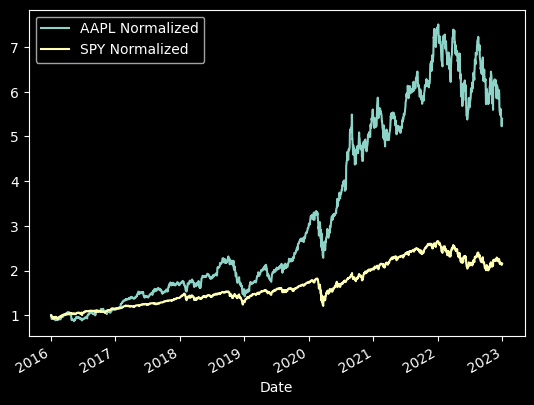

In [9]:
df[normalized_columns].plot()
plt.show()

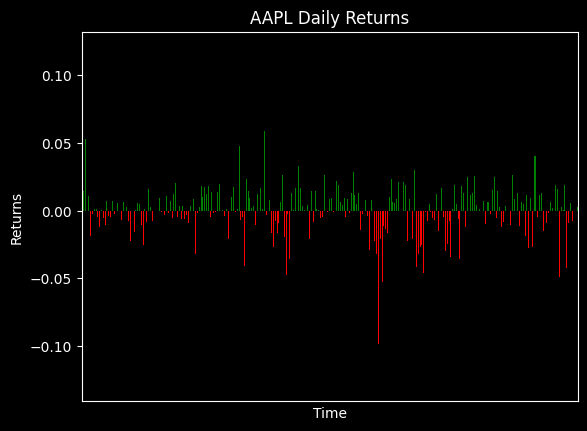

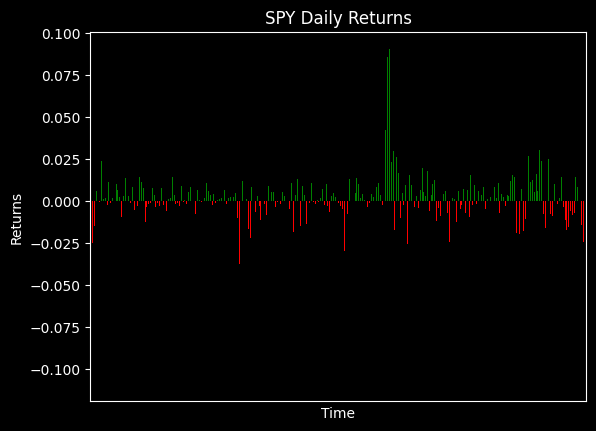

In [10]:
for daily_returns_column in daily_returns_columns:
    plot_returns(returns_df=df[daily_returns_column], title=daily_returns_column)
    plt.show()

## Indicator Calculations

In [11]:
indicator_columns = sum(
    [
        [
            f"{symbol}_ema_ratio",
            f"{symbol}_bbp",
            f"{symbol}_ppo",
            f"{symbol}_momentum_1",
            f"{symbol}_momentum_2",
        ]
        for symbol in tickers
    ],
    [],
)


def add_indicator_columns(df: pd.DataFrame):
    for symbol, normalized_column in zip(tickers, normalized_columns):
        normalized_prices: pd.Series = df[normalized_column]


        # compute ema ratio
        ema = normalized_prices.ewm(span=10).mean()
        df[f"{symbol}_ema_ratio"] = normalized_prices / ema - 1

        # compute bbp
        rolling_prices = normalized_prices.rolling(window=BBP_WINDOW_SIZE)
        sma = rolling_prices.mean()
        sm_std = rolling_prices.std()

        lower_band = sma - sm_std * BBP_NUM_STDDEVS
        upper_band = sma + sm_std * BBP_NUM_STDDEVS

        df[f"{symbol}_bbp"] = (normalized_prices - lower_band) / (
            upper_band - lower_band

        ) - 0.5


        # compute ppo
        short_ema = normalized_prices.ewm(span=PPO_SHORT_SPAN, adjust=False).mean()
        long_ema = normalized_prices.ewm(span=PPO_LONG_SPAN, adjust=False).mean()

        df[f"{symbol}_ppo"] = short_ema / long_ema - 1

        # compute momentum 1
        df[f"{symbol}_momentum_1"] = (
            normalized_prices / normalized_prices.shift(MOMENTUM_LOOKBACK_1) - 1
        )

        # compute momentum 2
        df[f"{symbol}_momentum_2"] = (
            normalized_prices / normalized_prices.shift(MOMENTUM_LOOKBACK_2) - 1
        )


add_indicator_columns(df=df)
df.head()

,AAPL,SPY,AAPL Normalized,SPY Normalized,AAPL Daily Returns,SPY Daily Returns,AAPL_ema_ratio,AAPL_bbp,AAPL_ppo,AAPL_momentum_1,AAPL_momentum_2,SPY_ema_ratio,SPY_bbp,SPY_ppo,SPY_momentum_1,SPY_momentum_2
Date,,,,,,,,,,,,,,,,
2016-01-04,23.977478,174.584015,1.000000,1.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN
2016-01-05,23.376621,174.879257,0.974941,1.001691,-0.025059,0.001691,-0.011434,NaN,-0.006747,NaN,NaN,0.000760,NaN,0.000455,NaN,NaN
2016-01-06,22.919147,172.673279,0.955861,0.989055,-0.019570,-0.012614,-0.018637,NaN,-0.015991,NaN,NaN,-0.007129,NaN,-0.002670,NaN,NaN
2016-01-07,21.951853,168.530594,0.915520,0.965327,-0.042205,-0.023991,-0.041083,NaN,-0.032461,NaN,NaN,-0.020966,NaN,-0.010968,NaN,NaN
2016-01-08,22.067934,166.680679,0.920361,0.954730,0.005288,-0.010977,-0.025942,NaN,-0.040856,NaN,NaN,-0.022817,NaN,-0.018812,NaN,NaN


In [12]:
lookahead_returns_column = f"{SYMBOL}_lookahead_returns"


def add_lookahead_returns_column(df: pd.DataFrame):
    df[lookahead_returns_column] = df[SYMBOL].shift(-LOOKAHEAD_RETURNS) / df[SYMBOL] - 1


add_lookahead_returns_column(df=df)
df[lookahead_returns_column].head()

Date
2016-01-04   -0.082487
2016-01-05   -0.057638
2016-01-06   -0.043694
2016-01-07    0.051529
2016-01-08    0.025577
Name: AAPL_lookahead_returns, dtype: float64

In [13]:
cleaned_df = df.dropna()
print(len(cleaned_df))
cleaned_df.head()

1732


,AAPL,SPY,AAPL Normalized,SPY Normalized,AAPL Daily Returns,SPY Daily Returns,AAPL_ema_ratio,AAPL_bbp,AAPL_ppo,AAPL_momentum_1,AAPL_momentum_2,SPY_ema_ratio,SPY_bbp,SPY_ppo,SPY_momentum_1,SPY_momentum_2,AAPL_lookahead_returns
Date,,,,,,,,,,,,,,,,,
2016-02-02,21.503483,165.152145,0.896820,0.945975,-0.020222,-0.018022,-0.021542,-0.235225,-0.035989,-0.103180,-0.055106,-0.002292,0.056945,-0.012002,-0.054025,-0.000210,0.044162
2016-02-03,21.929090,166.142197,0.914570,0.951646,0.019792,0.005995,-0.001776,-0.054271,-0.032388,-0.061922,0.031364,0.003008,0.126159,-0.010918,-0.049961,0.016850,0.004487
2016-02-04,22.105297,166.402786,0.921919,0.953139,0.008035,0.001568,0.005093,0.010945,-0.027340,-0.035510,0.032248,0.003737,0.121352,-0.009590,-0.036314,0.013167,-0.005797
2016-02-05,21.514902,163.232773,0.897296,0.934981,-0.026708,-0.019050,-0.017836,-0.200322,-0.030705,-0.019905,-0.028866,-0.012600,-0.269868,-0.013656,-0.031435,-0.029785,0.030419
2016-02-08,21.741449,161.035477,0.906745,0.922395,0.010530,-0.013461,-0.006131,-0.051584,-0.029447,-0.014795,-0.009379,-0.021253,-0.452493,-0.019463,-0.033868,-0.042500,-0.003368


In [14]:
X_tensor = torch.from_numpy(cleaned_df[indicator_columns].values)
Y_tensor = torch.from_numpy(cleaned_df[[lookahead_returns_column]].values)
X_tensor.shape, Y_tensor.shape

(torch.Size([1732, 10]), torch.Size([1732, 1]))

## Research

### Basic Neural Network Model

In [15]:
class BasicModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(10, 10),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.1),
            nn.Linear(10, 5),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.1),
            nn.Linear(5, 1),
        ])

    def forward(self, x):
        z = x
        for layer in self.layers:
            z = layer(z)
        return z

In [16]:
basic_model = BasicModel().double()
loss_criterion = nn.MSELoss()
optimizer = optim.Adam(params=basic_model.parameters(), lr=1e-3)

NUM_EPOCHS = 500
losses = []

print(basic_model)
print(loss_criterion)
print(optimizer)

BasicModel(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=10, out_features=5, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=5, out_features=1, bias=True)
  )
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [37]:
basic_model.train(True)

for epoch in range(NUM_EPOCHS):
    perm = torch.randperm(X_tensor.shape[0])
    X_tensor_shuffled = X_tensor[perm]
    Y_tensor_shuffled = Y_tensor[perm]

    optimizer.zero_grad()

    Y_hat_tensor_shuffled = basic_model(X_tensor_shuffled)
    loss = loss_criterion(Y_hat_tensor_shuffled, Y_tensor_shuffled)
    loss.backward()

    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch}: loss={losses[-1]}")

_ = basic_model.train(False)


Epoch 0: loss=0.0032468086696408357
Epoch 1: loss=0.0032446937333088545
Epoch 2: loss=0.0032631477969899837
Epoch 3: loss=0.0032450261367872177
Epoch 4: loss=0.0032609108246162053
Epoch 5: loss=0.003306407291410748
Epoch 6: loss=0.0033027925987480526
Epoch 7: loss=0.0032505688480492256
Epoch 8: loss=0.0033167769508066027
Epoch 9: loss=0.003217268497412333
Epoch 10: loss=0.0032105246723399443
Epoch 11: loss=0.003243191982794774
Epoch 12: loss=0.0032673000626646546
Epoch 13: loss=0.0032507052939597073
Epoch 14: loss=0.0032289490668632615
Epoch 15: loss=0.0032828229523481933
Epoch 16: loss=0.003246652030697122
Epoch 17: loss=0.003271861150469488
Epoch 18: loss=0.0032340593471517198
Epoch 19: loss=0.003218854003113463
Epoch 20: loss=0.0032471328512812666
Epoch 21: loss=0.0033096542973145805
Epoch 22: loss=0.0032393392782015897
Epoch 23: loss=0.003260181527721196
Epoch 24: loss=0.0032396402360931756
Epoch 25: loss=0.0032687525901577775
Epoch 26: loss=0.003272909429898855
Epoch 27: loss=0.00

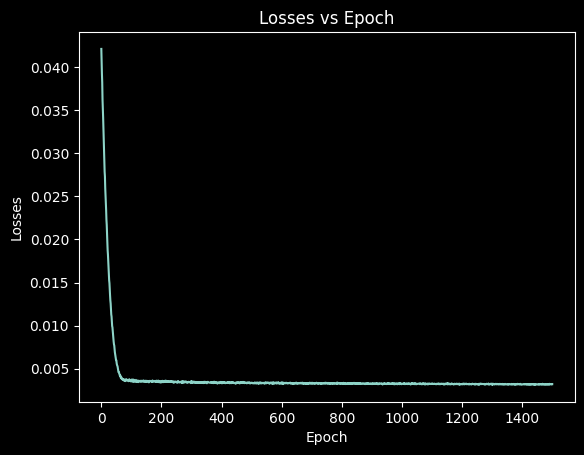

In [38]:
plt.plot(losses)
plt.title("Losses vs Epoch")
plt.ylabel("Losses")
plt.xlabel("Epoch")
plt.show()

In [19]:
predicted_lookahead_returns_column = f"{SYMBOL}_predicted_lookahead_returns"


def add_predicted_lookahead_returns_column(df: pd.DataFrame, model: nn.Module):
    with torch.no_grad():
        X_tensor = torch.from_numpy(df[indicator_columns].values)
        Y_hat_tensor = model(X_tensor)
    df[predicted_lookahead_returns_column] = Y_hat_tensor.numpy()


add_predicted_lookahead_returns_column(df=cleaned_df, model=basic_model)

In [67]:
predicted_lookahead_returns_uncertainty = (
    f"{SYMBOL}_predicted_lookahead_returns_uncertainty"
)
NUM_TRIALS = 32


def add_predicted_lookahead_returns_uncertainty_column(
    df: pd.DataFrame, model: nn.Module
):
    y_hats = []
    model.train(True)
    for _ in range(NUM_TRIALS):
        with torch.no_grad():
            X_tensor = torch.from_numpy(df[indicator_columns].values)
            Y_hat_tensor = model(X_tensor)
            y_hats.append(Y_hat_tensor.numpy())
    model.train(False)
    df[predicted_lookahead_returns_uncertainty] = np.std(y_hats, axis=0)


add_predicted_lookahead_returns_uncertainty_column(df=cleaned_df, model=basic_model)

In [68]:
lookahead_price_column = f"{SYMBOL}_lookahead_price"
predicted_lookahead_price_column = f"{SYMBOL}_predicted_lookahead_price"
predicted_lookahead_price_low_column = f"{SYMBOL}_predicted_lookahead_price_low"
predicted_lookahead_price_high_column = f"{SYMBOL}_predicted_lookahead_price_high"

NUM_STDDEVS = 2


def add_future_price_columns(df: pd.DataFrame):
    df[lookahead_price_column] = df[SYMBOL] * (df[lookahead_returns_column] + 1)
    df[predicted_lookahead_price_column] = df[SYMBOL] * (
        df[predicted_lookahead_returns_column] + 1
    )
    df[predicted_lookahead_price_low_column] = df[SYMBOL] * (
        df[predicted_lookahead_returns_column]
        + 1
        - NUM_STDDEVS * df[predicted_lookahead_returns_uncertainty]
    )
    df[predicted_lookahead_price_high_column] = df[SYMBOL] * (
        df[predicted_lookahead_returns_column]
        + 1
        + NUM_STDDEVS * df[predicted_lookahead_returns_uncertainty]
    )


add_future_price_columns(df=cleaned_df)
cleaned_df[
    [
        SYMBOL,
        lookahead_price_column,
        predicted_lookahead_price_column,
        predicted_lookahead_price_low_column,
        predicted_lookahead_price_high_column,
    ]
]

,AAPL,AAPL_lookahead_price,AAPL_predicted_lookahead_price,AAPL_predicted_lookahead_price_low,AAPL_predicted_lookahead_price_high
Date,,,,,
2016-02-02,21.503483,22.453115,21.650199,21.312155,21.988243
2016-02-03,21.929090,22.027494,22.098216,21.750101,22.446331
2016-02-04,22.105297,21.977152,22.312057,21.958804,22.665310
2016-02-05,21.514902,22.169361,21.753192,21.422516,22.083867
2016-02-08,21.741449,21.668222,22.053170,21.737368,22.368972
...,...,...,...,...,...
2022-12-09,141.369812,131.127060,143.002730,141.247879,144.757581
2022-12-12,143.686859,129.307236,145.664168,143.631965,147.696372
2022-12-13,144.661423,125.339409,146.763261,144.917270,148.609252


In [69]:
direction_accuracy = (
    (cleaned_df[lookahead_returns_column] > 0)
    == (cleaned_df[predicted_lookahead_returns_column] > 0)
).sum() / cleaned_df.shape[0]
direction_accuracy

0.6212471131639723

<Axes: xlabel='Date'>

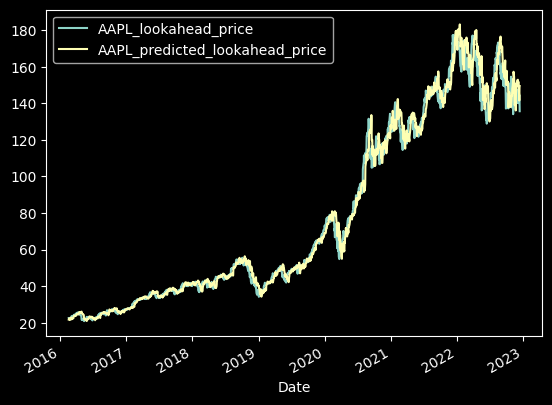

In [73]:
cleaned_df[
    [
        lookahead_price_column,
        predicted_lookahead_price_column,
    ]
].shift(LOOKAHEAD_RETURNS).plot()

In [75]:
val_df = yf.download(
    tickers=tickers, start=VAL_START_DATE, end=VAL_END_DATE, interval=INTERVAL
)["Adj Close"]
add_normalized_columns(df=val_df)
add_returns_columns(df=val_df)
add_indicator_columns(df=val_df)
add_lookahead_returns_column(df=val_df)
val_df = val_df.dropna()
add_predicted_lookahead_returns_column(df=val_df, model=basic_model)
add_predicted_lookahead_returns_uncertainty_column(df=val_df, model=basic_model)
add_future_price_columns(df=val_df)

[*********************100%%**********************]  2 of 2 completed

In [61]:
val_direction_accuracy = (
    (val_df[lookahead_returns_column] > 0)
    == (val_df[predicted_lookahead_returns_column] > 0)
).sum() / val_df.shape[0]
val_direction_accuracy

0.7136363636363636

<Axes: xlabel='Date'>

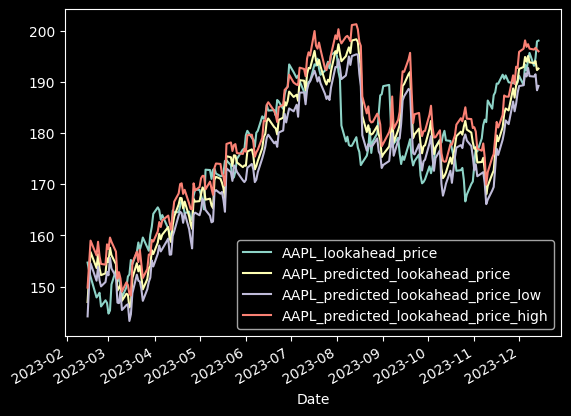

In [76]:
val_df[[lookahead_price_column, predicted_lookahead_price_column, predicted_lookahead_price_low_column, predicted_lookahead_price_high_column]].shift(
    LOOKAHEAD_RETURNS
).plot()

In [77]:
with torch.no_grad():
    X_val_tensor = torch.from_numpy(val_df[indicator_columns].values)
    Y_val_tensor = torch.from_numpy(val_df[[lookahead_returns_column]].values)
    Y_hat_val_tensor = basic_model(X_val_tensor)
    val_loss = loss_criterion(Y_hat_val_tensor, Y_val_tensor)
    print(val_loss.item())

0.00153335200759998


## Strategy

## Performance

## Testing